In [ ]:
#LIBREIAS GEOPANDAS, NUMPY
import xarray as xr
import geopandas as gpd # conda install --channel conda-forge geopandas
import matplotlib.ticker as ticker
import shapely.vectorized
import seaborn as sns
from datetime import datetime
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")


# Manipulación y tratamiento de Datos
import numpy as np
import pandas as pd

# Visualización de datos
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Modelación Arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Métrica de Evaluación
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics

# No presentar advertencias
import warnings
warnings.filterwarnings("ignore")
from netCDF4 import Dataset as NetCDFFile

cpu is available.


In [ ]:
pip install xarray dask netCDF4 bottleneck

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 16.0 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [ ]:
pip install geopandas

In [ ]:
pip install xarray

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
chirps = xr.open_dataset('/gdrive/My Drive/RAINFALLL/chirps-v2.0.monthly.nc')
#chirps = ('/gdrive/My Drive/RAINFALLL/chirps-v2.0.monthly.nc')

In [ ]:
chirps.info()

xarray.Dataset {
dimensions:
	latitude = 2000 ;
	longitude = 7200 ;
	time = 508 ;

variables:
	float32 latitude(latitude) ;
		latitude:units = degrees_north ;
		latitude:standard_name = latitude ;
		latitude:long_name = latitude ;
		latitude:axis = Y ;
	float32 longitude(longitude) ;
		longitude:units = degrees_east ;
		longitude:standard_name = longitude ;
		longitude:long_name = longitude ;
		longitude:axis = X ;
	float32 precip(time, latitude, longitude) ;
		precip:units = mm/month ;
		precip:standard_name = convective precipitation rate ;
		precip:long_name = Climate Hazards group InfraRed Precipitation with Stations ;
		precip:time_step = month ;
		precip:geostatial_lat_min = -50.0 ;
		precip:geostatial_lat_max = 50.0 ;
		precip:geostatial_lon_min = -180.0 ;
		precip:geostatial_lon_max = 180.0 ;
	datetime64[ns] time(time) ;
		time:standard_name = time ;
		time:axis = T ;

// global attributes:
	:Conventions = CF-1.6 ;
	:title = CHIRPS Version 2.0 ;
	:history = created by Climate H

In [ ]:
#CARGAR EL DATASET
#-------------------------------------------------------------------------------------
x = np.arange(-74.8, -71.9, 0.05)
y = np.arange(4.5, 7.3, 0.05)
xx, yy = np.meshgrid(x, y)
xnorm = (xx - xx.min()) / (xx.max() - xx.min())
ynorm = (yy - yy.min()) / (yy.max() - yy.min())

# CARGAR DATASET DE CHIRPS
chirps = xr.open_dataset('/gdrive/My Drive/RAINFALLL/chirps-v2.0.monthly.nc')

#SELECCIONAR LA VARIABLE DE PRECIPITACION
pr = chirps['precip']

# sSELECCIONAR LIMITES (xmin, xmax, ymin and ymax) -- TIEMPO Y PERIODO DE INTERES
pr_boyaca = pr.sel(longitude=slice(-74.8,-71.9), latitude=slice(4.5,7.3),time=slice('2020-01-01','2020-01-01')) #time=slice('1981','2020'))
v = pr_boyaca.to_numpy()

In [ ]:
# CONVERTIR DE XARRAY A GEOPANDAS
#-----------------------------------------------------------------------------
df_boyaca = pr_boyaca.to_dataframe().reset_index()
gdf_precip = gpd.GeoDataFrame(df_boyaca.precip, geometry=gpd.points_from_xy(df_boyaca.longitude,df_boyaca.latitude))
gdf_boyaca = gpd.read_file('/gdrive/My Drive/RAINFALLL/MGN_Departamento.shp') #crs="epsg:4326"

In [ ]:
v = np.squeeze(v) #np 3-D A 2-D

(4.475, 7.27499999999999)

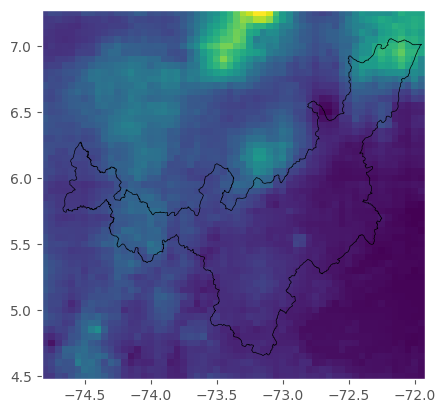

In [ ]:
#DELIMITAR EL DEPARTAMENTO DE BOYACA EN COLOR NEGRO
#-----------------------------------------------------------------------------
fig, ax = plt.subplots()
ax.pcolormesh(xx, yy, v)
xlim, ylim = ax.get_xlim(), ax.get_ylim()
gdf_boyaca.plot(ax=ax, color='none', edgecolor='k')
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

(4.475, 7.27499999999999)

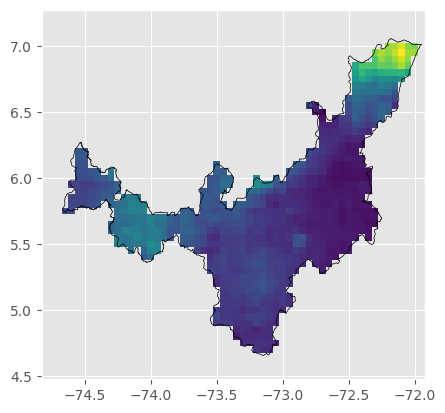

In [ ]:
#DELIMITAR EL DEPARTAMENTO DE BOYACA EN COLOR NEGRO Y QUITAR EXCEDENTE DE MAPA
#------------------------------------------------------------------------------------------
mask = shapely.vectorized.contains(gdf_boyaca.dissolve().geometry.item(), xx, yy)

fig, ax = plt.subplots()
ax.pcolormesh(xx, yy, np.where(mask, v, np.nan))
xlim, ylim = ax.get_xlim(), ax.get_ylim()
gdf_boyaca.plot(ax=ax, color='none', edgecolor='k')
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

In [ ]:
#CARGAR DATASET CON TODAS LA INFORMACION DESDE 1981 HASTA EL 2023.
#--------------------------------------------------------------------------------------------------------
pr_boyaca_all = pr.sel(longitude=slice(-74.8,-71.9), latitude=slice(4.5,7.3),time=slice('1981-01-01','2023-03-01')) #time=slice('1981','2020'))
pr_boyaca_all_mini = pr.sel(longitude=slice(-74.8,-74.6), latitude=slice(4.5,4.7),time=slice('1981-01-01','2023-03-01')) #time=slice('1981','2020'))
# convert xarray to geopandas
df_all = pr_boyaca_all_mini.to_dataframe().reset_index()

In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8112 entries, 0 to 8111
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       8112 non-null   datetime64[ns]
 1   latitude   8112 non-null   float64       
 2   longitude  8112 non-null   float64       
 3   precip     8112 non-null   float32       
dtypes: datetime64[ns](1), float32(1), float64(2)
memory usage: 221.9 KB


In [ ]:
df=df_all.copy()

In [ ]:
## pasar la columna "time" a formato datetime
df['datetime'] = pd.to_datetime(
    df['time'],
    format = '%d.%m.%Y %H:%M:%S'
)

## fijar el indice la variable datetime
df = df.set_index('datetime')

## organizar cronologicamente de forma ascendente
df.sort_index(inplace=True)

## finalmente eliminar colimna "time"
df = df.drop(columns=['time'])
df

,latitude,longitude,precip
datetime,,,
1981-01-01,4.524998,-74.775002,59.656879
1981-01-01,4.524998,-74.725006,55.540077
1981-01-01,4.524998,-74.675003,51.964622
1981-01-01,4.524998,-74.625008,60.566013
1981-01-01,4.574997,-74.775002,59.756550
...,...,...,...
2023-03-01,4.625000,-74.625008,225.511078
2023-03-01,4.674999,-74.775002,199.983551
2023-03-01,4.674999,-74.725006,198.153717


In [ ]:
# Función para generar las particiones preservando las características
# de la serie de tiempo

def train_val_test_split(df, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = df.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval  # Número de datos de prueba

    # Realizar partición
    train = df[0:Ntrain]
    val = df[Ntrain:Ntrain+Nval]
    test = df[Ntrain+Nval:]

    return train, val, test

# Prueba de la función
tr, vl, ts = train_val_test_split(df)

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (6489, 3)
Tamaño set de validación: (811, 3)
Tamaño set de prueba: (812, 3)


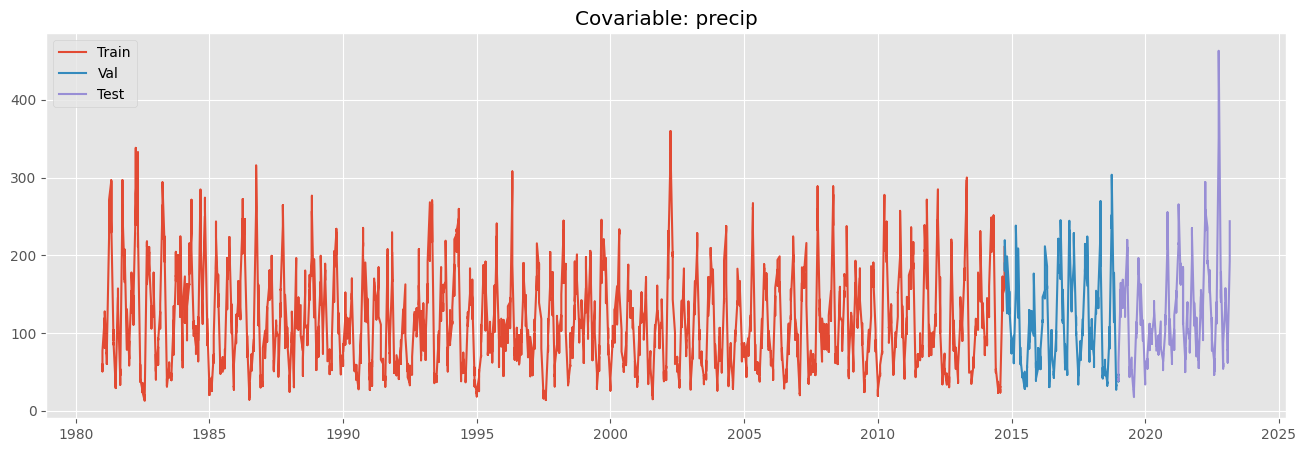

In [ ]:
covar = 2 # Índice de la covariable (columna del dataset) a graficar
col = df.columns[covar]

# Dibujar los sets de entrenamiento/validación/prueba para la covariable
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr[col], label='Train')
ax.plot(vl[col], label='Val')
ax.plot(ts[col], label='Test')
ax.set_title(f'Covariable: {col}')
plt.legend();

In [ ]:
def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado <-- <--- ¡esta parte de la función se ejecuta en este caso!
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [ ]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 10    # Hiperparámetro
OUTPUT_LENGTH = 1    # Modelo uni-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (6478, 10, 3), y_tr: (6478, 1, 1)
Set de validación - x_vl: (800, 10, 3), y_vl: (800, 1, 1)
Set de prueba - x_ts: (801, 10, 3), y_ts: (801, 1, 1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input, col_ref):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})
    - col_ref: parámetro adicional para especificar la columna que contiene
      la variable a predecir


    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    # *** Implementación adicional: determinar el índice de la columna
    # que contiene la variable a predecir
    col_ref = df.columns.get_loc(col_ref)

    # Número de instantes de tiempo de entrada y de covariables
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers" (1 por cada covariable de entrada)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys (teniendo en cuenta "col_ind")
    y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[col_ref].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[col_ref].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[col_ref]

In [ ]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset(data_in, col_ref = 'precip' )

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

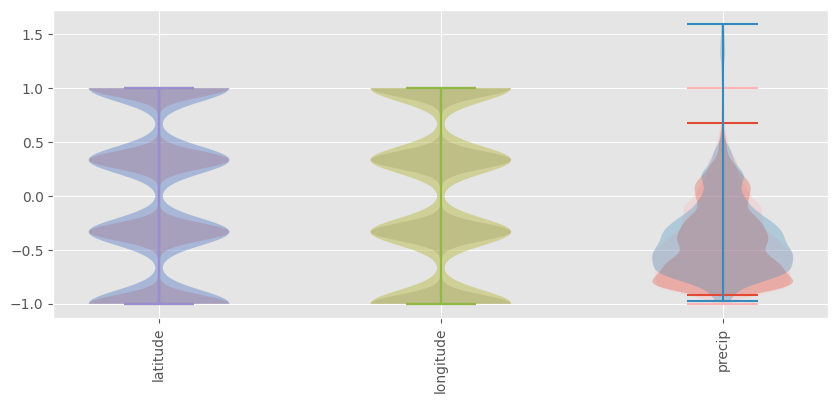

In [ ]:
# Y generemos una gráfica tipo violín para ver la distribución
# de los valores en cada covariable (entrada) y en la variable a
# predecir (salida)

fig, ax = plt.subplots(figsize=(10,4))
for i in range(3):
    ax.violinplot(dataset=x_tr_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_vl_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_ts_s[:,:,i].flatten(), positions=[i])

# Etiquetas eje horizontal
ax.set_xticks(list(range(3)))
ax.set_xticklabels(df.keys(), rotation=90)
ax.autoscale();

In [ ]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128 # Tamaño del estado oculto (h) y de la celdad de memoria (c) (128)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 60 meses x 3 (features)

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))

# Y lo único que cambia con respecto al modelo multivariado + uni-step es
# el tamaño del dato de salida
modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# permite tener errores en las mismas unidades de la precipitacion
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=5e-4) # 5e-5
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 200 # Hiperparámetro
BATCH_SIZE = 256 # Hiperparámetro
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/200
26/26 - 4s - loss: 0.2477 - val_loss: 0.2068 - 4s/epoch - 148ms/step
Epoch 2/200
26/26 - 1s - loss: 0.1994 - val_loss: 0.1862 - 1s/epoch - 46ms/step
Epoch 3/200
26/26 - 1s - loss: 0.1806 - val_loss: 0.1688 - 1s/epoch - 46ms/step
Epoch 4/200
26/26 - 2s - loss: 0.1659 - val_loss: 0.1574 - 2s/epoch - 58ms/step
Epoch 5/200
26/26 - 2s - loss: 0.1580 - val_loss: 0.1555 - 2s/epoch - 75ms/step
Epoch 6/200
26/26 - 2s - loss: 0.1538 - val_loss: 0.1559 - 2s/epoch - 73ms/step
Epoch 7/200
26/26 - 1s - loss: 0.1509 - val_loss: 0.1469 - 1s/epoch - 48ms/step
Epoch 8/200
26/26 - 1s - loss: 0.1484 - val_loss: 0.1441 - 1s/epoch - 49ms/step
Epoch 9/200
26/26 - 1s - loss: 0.1458 - val_loss: 0.1426 - 1s/epoch - 49ms/step
Epoch 10/200
26/26 - 1s - loss: 0.1430 - val_loss: 0.1409 - 1s/epoch - 46ms/step
Epoch 11/200
26/26 - 1s - loss: 0.1409 - val_loss: 0.1401 - 1s/epoch - 49ms/step
Epoch 12/200
26/26 - 1s - loss: 0.1400 - val_loss: 0.1353 - 1s/epoch - 42ms/step
Epoch 13/200
26/26 - 1s - loss: 0.13

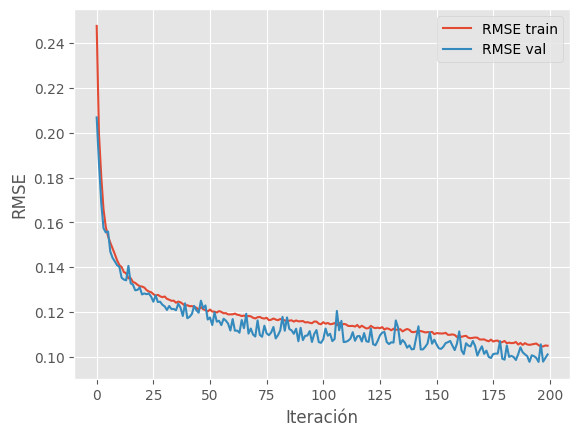

In [ ]:
# Graficar curvas de entrenamiento y validación
# para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

In [ ]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=1)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=1)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=1)


# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

26/26 [==============================] - 0s 12ms/step - loss: 0.0989
Comparativo desempeños:
  RMSE train:	 0.100
  RMSE val:	 0.097
  RMSE test:	 0.099


In [ ]:
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)

    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [ ]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, modelo, scaler)
y_ts_pred

array([ 44.678905,  47.81494 ,  85.43427 , 152.05923 , 140.86827 ,
       141.59225 , 147.46777 , 155.04112 , 133.81374 , 130.49184 ,
       147.56512 , 146.71619 , 130.76376 , 130.88152 , 136.53339 ,
       143.70575 , 133.78679 , 139.7155  , 126.67104 , 159.06061 ,
       163.05936 , 155.88509 , 161.07727 , 163.24228 , 148.63042 ,
       146.50908 , 152.66357 , 150.73796 , 138.46246 , 139.59668 ,
       141.04713 , 150.72624 , 142.33449 , 152.24333 , 132.8479  ,
       133.05345 , 130.26543 , 129.63217 , 136.36433 , 129.17015 ,
       128.11586 , 125.037865, 126.5411  , 117.74088 , 124.20088 ,
       127.8215  , 123.143326, 121.08387 , 127.7198  , 137.12195 ,
       132.26617 , 210.84454 , 205.02995 , 192.06857 , 200.43263 ,
       205.42638 , 180.05057 , 175.47273 , 197.99707 , 201.13312 ,
       188.24063 , 175.06136 , 199.94589 , 213.65404 , 193.93486 ,
       193.97289 , 118.69526 ,  44.18624 ,  51.046455,  52.90786 ,
        45.347878,  45.10455 ,  46.30558 ,  48.12842 ,  44.925

In [ ]:
rmse = modelo.evaluate(x=x_ts_s, y=y_ts_pred, verbose=1)
# Imprimir resultados en pantalla
print('Comparativo desempeño:')
print(f'  RMSE:\t {rmse_tr:.3f}')

26/26 [==============================] - 2s 17ms/step - loss: 129.1520
Comparativo desempeño:
  RMSE:	 0.100


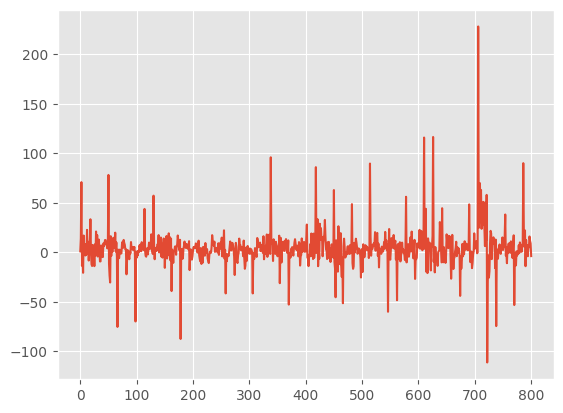

In [ ]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);

In [ ]:
def evaluacion_metrica(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
evaluacion_metrica(y_ts.flatten(),y_ts_pred)

Evaluation metric results:-
MSE is : 377.6928077886647
MAE is : 10.636782517593899
RMSE is : 19.434320358290503
MAPE is : 9.686891398645415
R2 is : 0.9210237862805676

